<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/Text_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 645kB 3.4MB/s 
     |████████████████████████████████| 3.8MB 15.6MB/s 
     |████████████████████████████████| 890kB 34.8MB/s 
     |████████████████████████████████| 1.1MB 34.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=edb824c37b9d19dd6d6478bc478aff9fce6782f6aaec0c7f66a7a96e14f8fc6e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Imports

In [0]:
import torch
import random
import re
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from torchtext.vocab import GloVe
from transformers import BertModel, BertTokenizer

# Arguments

In [0]:
args = {
    "bert_tokenizer": "bert-base-uncased",
    "bert_model": "bert-base-uncased",
    "seed": 1234,
    "bert_embedding_dim": 768,
    "use_glove": False,
    "glove_embedding_dim": 300,
    "max_vocab_size": 20000,
    "batch_size": 10,
    "num_filters": 100,
    "filter_sizes": [1,1,1],
    "output_dim": 11,
    "dropout": 0.5,
    "epochs": 10
}

# Text pre-processor

In [0]:
def preprocessor(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = (re.sub('[\W]+', ' ', text.lower()) +
          ' '.join(emoticons).replace('-', '')) 
  return text.split()

# Setup Bert Tokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained(args['bert_model'])

In [6]:
max_input_length = tokenizer.max_model_input_sizes[args['bert_model']]

print(max_input_length)

512


# Tokenize text

In [0]:
def tokenize(tweet):
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

# Load & Generate Data

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')

random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True

if args['use_glove']:
  TEXT = data.Field(batch_first=True,
                    tokenize=preprocessor,
                    use_vocab=True,
                    sequential=True)

else:
  TEXT = data.Field(batch_first = True,
                    use_vocab = False,
                    tokenize = tokenize,
                    preprocessing = tokenizer.convert_tokens_to_ids,
                    init_token = tokenizer.cls_token_id,
                    eos_token = tokenizer.sep_token_id,
                    pad_token = tokenizer.pad_token_id,
                    unk_token = tokenizer.unk_token_id)

LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = args['batch_size'],
    device = device
)

# Load GloVe vectors

In [0]:
if args['use_glove']:
  TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300), 
                   max_size=args['max_vocab_size'])
  print(f"\nUnique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

# Setup Batch Wrapper

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

# Build the Model

Load the pretrained bert model from the HuggingFace transformers library.

https://github.com/huggingface/transformers


In [12]:
bert = BertModel.from_pretrained(args['bert_model'])

We use the pre-trained bert transformer model to produce embeddings which are then fed into the TextCNN architecture proposed by Yoon Kim at: https://arxiv.org/abs/1408.5882

In [0]:
class TextCNN(nn.Module):
  def __init__(self, n_filters, filter_sizes, output_dim, dropout):
    super().__init__()

    if args['use_glove']:
      embedding_dim = args['glove_embedding_dim']
      self.embedding = nn.Embedding(len(TEXT.vocab), embedding_dim)
    else: 
      self.bert = bert 
      embedding_dim = 768

    self.convs = nn.ModuleList([
                                nn.Conv2d(in_channels = 1,
                                          out_channels = n_filters,
                                          kernel_size = (fs, embedding_dim)) 
                                for fs in filter_sizes])
    
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, text):
    if args['use_glove']:
      embedded = self.embedding(text)
    else:
      with torch.no_grad():
        embedded = self.bert(text)[0]
    
    embedded = embedded.unsqueeze(1)
    
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    
    cat = self.dropout(torch.cat(pooled, dim = 1))
    
    return self.fc(cat)

In [14]:
model = TextCNN(n_filters=args['num_filters'], 
                filter_sizes=args['filter_sizes'],
                output_dim=args['output_dim'], 
                dropout=args['dropout'])

model

TextCNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

Next we freeze the parameters which are a part of the Bert Transformers model. 

In [0]:
if args['use_glove'] is False:
  for name, param in model.named_parameters():                
      if name.startswith('bert'):
          param.requires_grad = False

In [16]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

convs.0.weight
convs.0.bias
convs.1.weight
convs.1.bias
convs.2.weight
convs.2.bias
fc.weight
fc.bias


# Train the Model

In [0]:
import torch.optim as optim
import pandas as pd

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We evaluate using the Jaccard Index and the macro and micro F1's as there are more suitable for multi-label text classification.

In [0]:
from sklearn.metrics import f1_score, jaccard_score

In [0]:
def metricize(preds, y):
  f1_macro = f1_score(y, preds.round(), average='macro')
  f1_micro = f1_score(y, preds.round(), average='micro')
  jaccard = jaccard_score(y, preds.round(), average='samples')

  return {
      'f1_macro': f1_macro,
      'f1_micro': f1_micro,
      'jaccard': jaccard
  }

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()
    
    if args['use_glove']:
      predictions = model(batch.Tweet)
    else:
      predictions = model(batch.Tweet).squeeze(1)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0

  model.eval()

  preds_list = []
  labels_list = []

  with torch.no_grad():
    
    for batch in iterator:

      if args['use_glove']:
        predictions = model(batch.Tweet)
      else:
        predictions = model(batch.Tweet).squeeze(1)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list)), preds_list, labels_list

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train the model for 10 epochs and record the training and validation loss.


In [25]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_acc = []
valid_acc = []

for epoch in range(args['epochs']):

    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_metrics, _, _ = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        if args['use_glove']:
          torch.save(model.state_dict(), 'glove-cnn-model.pt')
        else:
          torch.save(model.state_dict(), 'bert-cnn-model.pt')

    train_jaccard = train_metrics['jaccard']
    train_micro = train_metrics['f1_micro']
    train_macro = train_metrics['f1_macro']

    valid_jaccard = valid_metrics['jaccard']
    valid_micro = valid_metrics['f1_micro']
    valid_macro = valid_metrics['f1_macro']

    train_acc.append(train_jaccard)
    valid_acc.append(valid_jaccard)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Jaccard: {train_jaccard*100:.2f}% | Train F1 Micro: {train_micro*100:.2f}% | Train F1 Macro: {train_macro*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Jaccard: {valid_jaccard*100:.2f}%  | Val. F1 Micro: {valid_micro*100:.2f}%  | Val. F1 Macro: {valid_macro*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 39s
	Train Loss: 0.394 | Train Jaccard: 34.38% | Train F1 Micro: 48.71% | Train F1 Macro: 31.17%
	 Val. Loss: 0.323 | Val. Jaccard: 48.49%  | Val. F1 Micro: 62.77%  | Val. F1 Macro: 43.13%
Epoch: 02 | Epoch Time: 0m 39s
	Train Loss: 0.341 | Train Jaccard: 46.41% | Train F1 Micro: 60.44% | Train F1 Macro: 42.52%
	 Val. Loss: 0.319 | Val. Jaccard: 51.70%  | Val. F1 Micro: 65.23%  | Val. F1 Macro: 43.44%
Epoch: 03 | Epoch Time: 0m 39s
	Train Loss: 0.330 | Train Jaccard: 47.40% | Train F1 Micro: 61.61% | Train F1 Macro: 44.17%
	 Val. Loss: 0.315 | Val. Jaccard: 51.76%  | Val. F1 Micro: 65.45%  | Val. F1 Macro: 45.51%
Epoch: 04 | Epoch Time: 0m 39s
	Train Loss: 0.320 | Train Jaccard: 49.47% | Train F1 Micro: 63.53% | Train F1 Macro: 46.89%
	 Val. Loss: 0.311 | Val. Jaccard: 51.70%  | Val. F1 Micro: 65.39%  | Val. F1 Macro: 45.94%
Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 0.314 | Train Jaccard: 50.25% | Train F1 Micro: 64.15% | Train F1 Macro: 48.07%
	 Val. Loss:

# Visualize the training and validation loss

In [0]:
import matplotlib.pyplot as plt

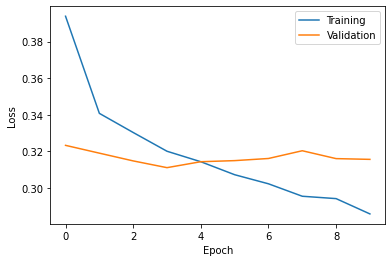

In [27]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

# Visualize the training and validation accuracy (jaccard)

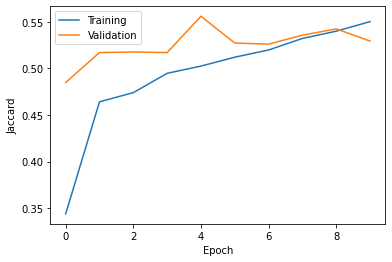

In [29]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel('Epoch')
plt.ylabel('Jaccard')
plt.legend(['Training', 'Validation'])

# Assess model performance on testing data

In [30]:
if args['use_glove']:
  model.load_state_dict(torch.load('glove-cnn-model.pt'))
else:
  model.load_state_dict(torch.load('bert-cnn-model.pt'))

test_loss, test_metrics, preds_list, labels_list = evaluate(model, test_iterator, criterion)

test_jaccard = test_metrics['jaccard']
test_micro = test_metrics['f1_micro']
test_macro = test_metrics['f1_macro']

print(f'Test Loss: {test_loss:.3f} | Test Jaccard: {test_jaccard*100:.2f}% | Test F1 Micro: {test_micro*100:.2f}% | Test F1 Macro: {test_macro*100:.2f}%')

Test Loss: 0.310 | Test Jaccard: 52.93% | Test F1 Micro: 66.38% | Test F1 Macro: 47.23%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion matrix & Classification report

In [31]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

print(multilabel_confusion_matrix(np.vstack(labels_list), np.vstack(preds_list).round()))
print(classification_report(np.vstack(labels_list), np.vstack(preds_list).round()))

[[[1975  183]
  [ 310  791]]

 [[2827    7]
  [ 415   10]]

 [[1936  224]
  [ 358  741]]

 [[2724   50]
  [ 214  271]]

 [[1671  146]
  [ 333 1109]]

 [[2676   67]
  [ 311  205]]

 [[1835  281]
  [ 356  787]]

 [[2850   34]
  [ 331   44]]

 [[2168  131]
  [ 450  510]]

 [[3089    0]
  [ 168    2]]

 [[3085   21]
  [ 145    8]]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1101
           1       0.59      0.02      0.05       425
           2       0.77      0.67      0.72      1099
           3       0.84      0.56      0.67       485
           4       0.88      0.77      0.82      1442
           5       0.75      0.40      0.52       516
           6       0.74      0.69      0.71      1143
           7       0.56      0.12      0.19       375
           8       0.80      0.53      0.64       960
           9       1.00      0.01      0.02       170
          10       0.28      0.05      0.09       153

   micro avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()

  if args['use_glove']:
    tokenized = preprocessor(tweet)
    indexed = [TEXT.vocab.stoi[token] for token in tokenized]
  else:
    tokens = tokenizer.tokenize(tweet)
    tokens = tokens[:max_input_length-2]
    indexed = [tokenizer.cls_token_id] + tokenizer.convert_tokens_to_ids(tokens) + [tokenizer.sep_token_id]
    
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())
  return preds

In [33]:
preds = predict_emotion(model, tokenizer, "Good music, I love that shit.")

vals = []
for p in preds[0]:
  for val in p:
    vals.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {vals[i]}")

ANGER: 0.15674443542957306
ANTICIPATION: 0.08907847106456757
DISGUST: 0.12354488670825958
FEAR: 0.029301801696419716
JOY: 0.9063069820404053
LOVE: 0.6477935910224915
OPTIMISM: 0.6407592296600342
PESSIMISM: 0.019086146727204323
SADNESS: 0.03911391273140907
SURPRISE: 0.017089931294322014
TRUST: 0.2404278665781021


# Model performance on longer text

In [0]:
import os

In [35]:
text_1 = (
    "I'm only 24, and have worked part time jobs since I graduated from college." 
    " With everything going on, I've been furloughed from both of my part time jobs."
    " Well one offered me full time, and I was able to negotiate the salary up a full dollar per hour! And it has benefits and everything!" 
    " I know it's not a big deal but I'm just so excited and can't really tell anyone"
    " especially as I haven't spoken to my other part time job yet. Just hoping everything works out well, and that I have money for grad school in the fall!"
)

text_2 = (
    "I worked my ass off to graduate with my Bachelor's in 3 years."
    "My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'."
    "And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my"
    " professors snet me a graduation card. They were there for all of it. Still, not a single word about it."
    " I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements."
    " I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?"
    " I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back."
    " This really sucks."
)

preds = predict_emotion(model, tokenizer, text_2)

vals = []
for p in preds[0]:
  for val in p:
    vals.append(val)

# print(os.linesep.join(["I'm only 24, and have worked part time jobs since I graduated from college.", 
#                        "With everything going on, I've been furloughed from both of my part time jobs.",
#                        "Well one offered me full time, and I was able to negotiate the salary up a full dollar per hour!", 
#                        "And it has benefits and everything! I know it's not a big deal but I'm just so excited and", 
#                        "can't really tell anyone, especially as I haven't spoken to my other part time job yet.", 
#                        "Just hoping everything works out well, and that I have money for grad school in the fall!"]))

print(os.linesep.join(["I worked my ass off to graduate with my Bachelor's in 3 years.", 
                      "My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'.",
                      "And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my",
                      "professors snet me a graduation card. They were there for all of it. Still, not a single word about it.",
                      "I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements.",
                      "I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?",
                      "I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back.",
                      "This really sucks."]))


print()

print("Text length: 138 words")

print()
for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {vals[i]:.2f}")

I worked my ass off to graduate with my Bachelor's in 3 years.
My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'.
And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my
professors snet me a graduation card. They were there for all of it. Still, not a single word about it.
I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements.
I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?
I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back.
This really sucks.

Text length: 138 words

ANGER: 0.13
ANTICIPATION: 0.01
DISGUST: 0.19
FEAR: 0.00
JOY: 0.12
LOVE: 0.00
OPTIMISM: 0.20
PESSIMISM: 0.04
SADNESS: 0.16
SURPRISE: 0.00
TRUST: 0.01
